In [35]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = '/content/drive/MyDrive/dataset/drawings/spiral/training'
validation_dir = '/content/drive/MyDrive/dataset/drawings/spiral/testing'


BATCH_SIZE = 9
IMG_SIZE = (160, 160)



train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 144 files belonging to 2 classes.


In [36]:

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)




Found 60 files belonging to 2 classes.


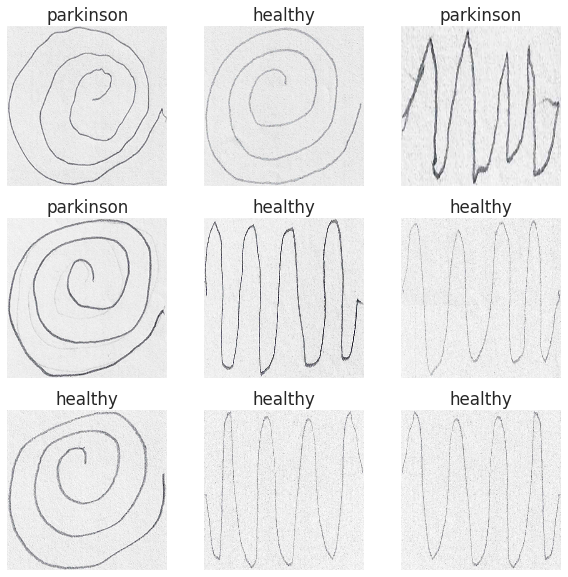

In [37]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


In [39]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip(),
  tf.keras.layers.experimental.preprocessing.RandomRotation(360),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.1),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2),
  

])

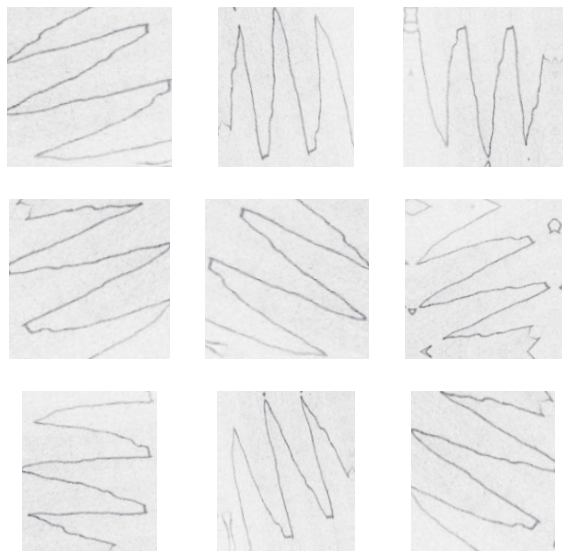

In [40]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [41]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [42]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [43]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(9, 5, 5, 1280)


In [44]:
base_model.trainable = False

In [45]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [46]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(9, 1280)


In [47]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(9, 1)


In [48]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [49]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [50]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [51]:
len(model.trainable_variables)

2

In [52]:
initial_epochs = 20
 
loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 [==============================] - 3s 135ms/step - loss: 1.2267 - accuracy: 0.5167


In [53]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.23
initial accuracy: 0.52


In [54]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
16/16 [==============================] - 7s 231ms/step - loss: 1.0899 - accuracy: 0.4931 - val_loss: 1.0329 - val_accuracy: 0.5000
Epoch 2/20
16/16 [==============================] - 4s 228ms/step - loss: 0.9410 - accuracy: 0.4792 - val_loss: 0.8922 - val_accuracy: 0.4833
Epoch 3/20
16/16 [==============================] - 4s 233ms/step - loss: 0.8558 - accuracy: 0.4792 - val_loss: 0.7986 - val_accuracy: 0.5167
Epoch 4/20
16/16 [==============================] - 4s 228ms/step - loss: 0.8105 - accuracy: 0.4722 - val_loss: 0.7516 - val_accuracy: 0.5000
Epoch 5/20
16/16 [==============================] - 4s 234ms/step - loss: 0.7977 - accuracy: 0.5069 - val_loss: 0.7210 - val_accuracy: 0.5333
Epoch 6/20
16/16 [==============================] - 4s 235ms/step - loss: 0.8001 - accuracy: 0.4931 - val_loss: 0.7051 - val_accuracy: 0.5333
Epoch 7/20
16/16 [==============================] - 4s 230ms/step - loss: 0.7917 - accuracy: 0.5208 - val_loss: 0.6849 - val_accuracy: 0.5333
Epoch 

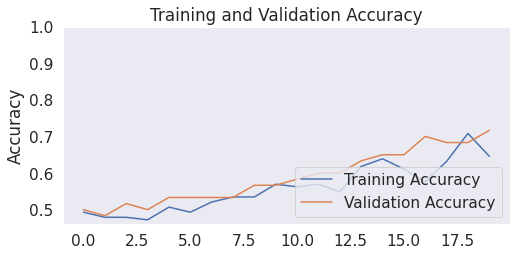

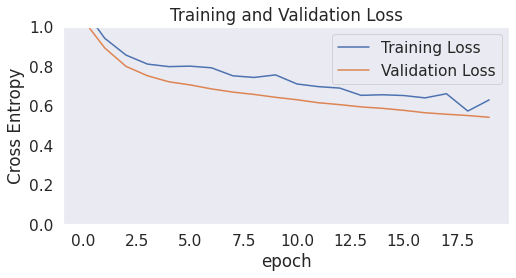

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.grid(False)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.grid(False)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [56]:
base_model.trainable = True

In [57]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [58]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/70),
              metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [59]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [60]:
len(model.trainable_variables)

56

In [61]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40
16/16 [==============================] - 11s 413ms/step - loss: 0.5912 - accuracy: 0.6736 - val_loss: 0.5062 - val_accuracy: 0.8000
Epoch 21/40
16/16 [==============================] - 6s 353ms/step - loss: 0.5602 - accuracy: 0.6806 - val_loss: 0.4729 - val_accuracy: 0.7667
Epoch 22/40
16/16 [==============================] - 6s 359ms/step - loss: 0.5122 - accuracy: 0.7361 - val_loss: 0.4509 - val_accuracy: 0.7500
Epoch 23/40
16/16 [==============================] - 6s 355ms/step - loss: 0.4889 - accuracy: 0.7292 - val_loss: 0.4340 - val_accuracy: 0.7500
Epoch 24/40
16/16 [==============================] - 6s 353ms/step - loss: 0.4934 - accuracy: 0.7500 - val_loss: 0.4152 - val_accuracy: 0.8167
Epoch 25/40
16/16 [==============================] - 6s 352ms/step - loss: 0.4355 - accuracy: 0.7847 - val_loss: 0.4024 - val_accuracy: 0.7833
Epoch 26/40
16/16 [==============================] - 6s 352ms/step - loss: 0.4568 - accuracy: 0.7500 - val_loss: 0.3895 - val_accuracy: 0.816

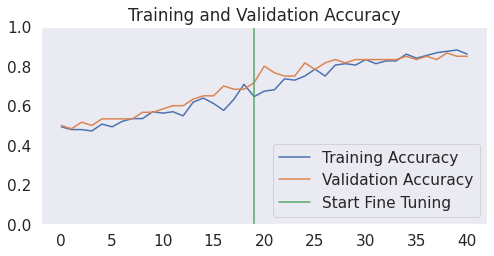

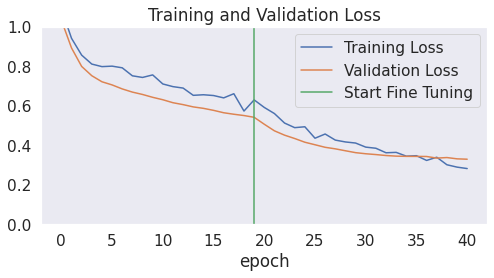

In [62]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.grid(False)
plt.plot(acc, label='Training Accuracy') # marker = 'o'
plt.plot(val_acc, label='Validation Accuracy') # marker = 'o'
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 2)
plt.grid(False)
plt.plot(loss, label='Training Loss') # marker = 'o'
plt.plot(val_loss, label='Validation Loss') #marker = 'o'
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [63]:
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 1s 128ms/step - loss: 0.3293 - accuracy: 0.8500
Test accuracy : 0.8500000238418579


Predictions:
 [0 1 1 1 0 1 1 1 1]
Labels:
 [0 1 1 1 0 1 1 0 1]


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


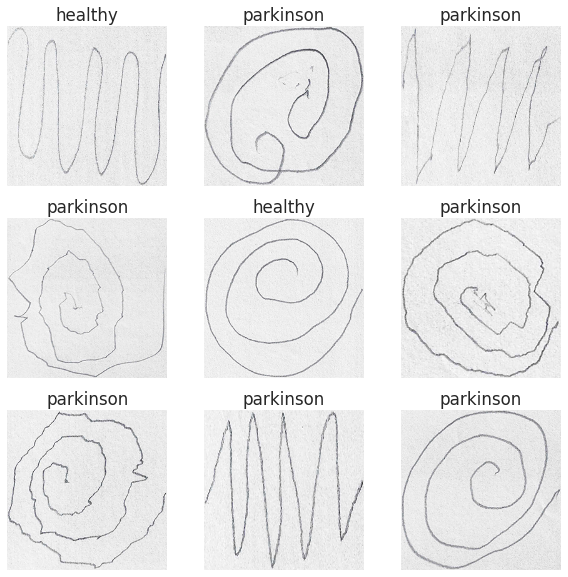

In [64]:
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten() 
 
 
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
 
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
 
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.grid(False)
  plt.axis("off")
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])

saved_model_path = "/content/drive/MyDrive/model_new.hdf5" 
model.save(saved_model_path)

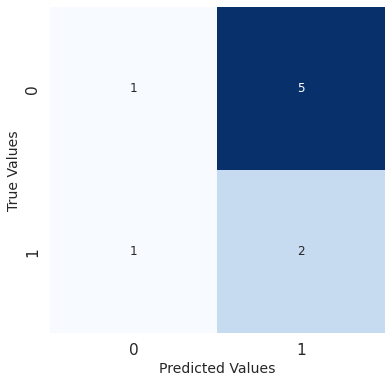

In [65]:


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, predictions)
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Blues');
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.show()



In [66]:
def plot_confusion_matrix(cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.grid(False)
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
     for j in range (cm.shape[1]):
       plt.text(j, i, cm[i, j],
       horizontalalignment="center",
       color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1 5]
 [1 2]]


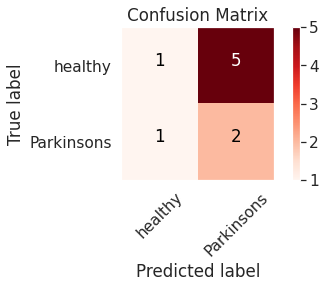

In [67]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true=labels, y_pred=predictions)
cm_plot_labels = ['healthy','Parkinsons']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_true=labels,y_pred=predictions))


              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.29      0.67      0.40         3

    accuracy                           0.33         9
   macro avg       0.39      0.42      0.33         9
weighted avg       0.43      0.33      0.30         9

